In [3]:
import re
import os
import pandas as pd
import concurrent.futures
from tqdm import tqdm
from pathlib import Path

SRC_DIR = Path('./images')
ACRONYMS = ['69', 'BBC', 'BBW', 'BDSM', 'CFNM', 'DP', 'GILF', 'MILF', 'PAWG', 'POV']

In [28]:
def process_string(input_string):
    word_list = re.findall('[A-Z][^A-Z]*', input_string)

    joined_words = []
    temp_word = ""
    for word in word_list:
        if word.endswith(" "):
            temp_word += word
        else:
            if temp_word:
                joined_words.append(temp_word + word)
                temp_word = ""
            else:
                joined_words.append(word)

    final_words = []
    temp_word = ""
    for word in joined_words:
        if len(word) == 1 and word.isupper():
            temp_word += word
        elif len(word) > 1 and word[1] == " ":
            temp_word += word
        elif len(word) > 1 and word[-2] == " ":
            final_words.append(temp_word)
            temp_word = ""
            temp_word += word

        else:
            if temp_word:
                final_words.append(temp_word)
                temp_word = ""
            final_words.append(word)
    if temp_word:
        final_words.append(temp_word)

    word_list = [w for w in final_words if w != ""]
    
    new_list = []
    for word in word_list:
        match = re.match(r"([a-zA-Z]+)([0-9]+)", word)
        if match:
            new_list.append(match.group(1))
            new_list.append(int(match.group(2)))
        else:
            new_list.append(word)
    return new_list


def split_and_verify_acronyms(words_list, acronyms):
    out = []

    for word in words_list:
        word = str(word)
        if word.isupper():
            for acronym in acronyms:
                if acronym in word:
                    out.append(acronym)
                    word = word.replace(acronym, "")
        out.append(word)

    return [w for w in out if w != ""]


def split_and_unify_tags(tags_list: list[str]):
    out = []
    acronyms = []
    for tag in tags_list:
        for acronym in ACRONYMS:
            if acronym in tag:
                tag = tag.replace(acronym, "").strip()
                if acronym not in acronyms:
                    acronyms.append(acronym)
        out.append(tag)

    result = list(set(out + acronyms))
    # if elements is without " " and is present in other elements with " " remove the one without " "
    for tag in result:
        if tag in out:
            for other_tag in out:
                if tag in other_tag and tag != other_tag:
                    result.remove(tag)
                    break

    return result


def process_line(line_string: str) -> list[str]:
    words_list = process_string(line_string)
    words_list = split_and_verify_acronyms(words_list, ACRONYMS)
    return [word.replace("  ", " ").strip() for word in words_list]

In [29]:
def parse_gallery_info(filepath: Path):
    # Get all the filenames as list
    filenames = []
    for f in os.listdir(filepath.parent):
        if not f.startswith(".") and not f.endswith(".txt"):
            filenames.append(f)

    with open(filepath, 'r') as file:
        content = file.readlines()

    info = {}
    spl = filepath.as_posix().split("/")
    info['category'] = spl[1]
    info['gallery_name'] = spl[2]
    info['filenames'] = filenames
    for line in content:
        if line.startswith("Channel"):
            info['channel'] = line.removeprefix("Channel: : ").removesuffix("\n")
        elif line.startswith("Models"):
            info['models'] = process_line(line.removeprefix("Models:: ").removesuffix(" + Suggest\n"))
        elif line.startswith("Categories"):
            info['categories'] = process_line(line.removeprefix("Categories:: ").removesuffix(" + Suggest\n"))
        elif line.startswith("Tags List"):
            info['tags_list'] = split_and_unify_tags(process_line(line.removeprefix("Tags List:: ").removesuffix("\n")))
        elif line.startswith("Stats"):
            splitted = line.removeprefix("Stats:: ").removesuffix("\n").split("; ")
            info['rating'] = splitted[0].removeprefix("Rating: ")
            info['views'] = splitted[1].removeprefix("Views: ")

    return info

In [30]:
def process_gallery(category_name: str, gallery: str):
    gallery_info_path = SRC_DIR / category_name / gallery / 'gallery_info.txt'
    if gallery_info_path.exists():
        gallery_info = parse_gallery_info(gallery_info_path)
        return gallery_info

In [31]:
def process_category(category_name: str):
    category_path = SRC_DIR / category_name
    category_galleries = [
        gallery
        for gallery in os.listdir(category_path)
        if (category_path / gallery).is_dir()
    ]

    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_gallery = [
            executor.submit(process_gallery, category_name, gallery)
            for gallery in category_galleries[:5]
        ]

        for future in tqdm(
                concurrent.futures.as_completed(future_to_gallery),
                total=len(future_to_gallery),
                desc=f"Processing {category_name}",
                unit="gallery"
        ):
            gallery_info = future.result()
            if gallery_info:
                results.append(gallery_info)

    return results

In [32]:
def crawl_images_folder():
    categories = [category for category in os.listdir(SRC_DIR) if (SRC_DIR / category).is_dir()]

    all_galleries_info = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_category = [executor.submit(process_category, category) for category in categories]
        for future in tqdm(concurrent.futures.as_completed(future_to_category), total=len(future_to_category),
                           desc="Processing categories", unit="category"):
            category_galleries_info = future.result()
            all_galleries_info.extend(category_galleries_info)

    return all_galleries_info

In [33]:
# Crawl the folder and get all galleries info
all_galleries_info = crawl_images_folder()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(all_galleries_info)

Processing yoga-pants: 100%|██████████| 5/5 [00:00<00:00, 36157.79gallery/s]

Processing teen: 100%|██████████| 5/5 [00:00<00:00, 9981.68gallery/s]

Processing non-nude:   0%|          | 0/5 [00:00<?, ?gallery/s]

Processing non-nude: 100%|██████████| 5/5 [00:00<00:00, 325.60gallery/s]

Processing selfie:   0%|          | 0/5 [00:00<?, ?gallery/s]


Processing saggy-tits: 100%|██████████| 5/5 [00:00<00:00, 1348.13gallery/s]

Processing smoking:   0%|          | 0/5 [00:00<?, ?gallery/s]

Processing smoking: 100%|██████████| 5/5 [00:00<00:00, 347.03gallery/s]

Processing categories:  21%|██        | 8/38 [00:00<00:00, 41.90category/s]

Processing homemade: 100%|██████████| 5/5 [00:00<00:00, 1517.92gallery/s]

Processing spreading:   0%|          | 0/5 [00:00<?, ?gallery/s]

Processing boots:   0%|          | 0/5 [00:00<?, ?gallery/s]


Processing maid: 100%|██████████| 5/5 [00:00<00:00, 626.31gallery/s]

Processing jeans:   0%|          | 0/5 [00:00<?, ?gallery/s]

Processing tattoo:   

In [34]:
df

,category,gallery_name,filenames,channel,models,categories,tags_list,rating,views
0,yoga-pants,18-year-old-girl-exposes-big-tits-while-seduci...,"[33817413_011_2ae8.jpg, 33817413_009_3dd8.jpg,...",HD Sex 18 Pics,[Jeycy Fox],"[Hardcore, Doggy Style, Yoga Pants, Teen, Ass,...","[Leggings Ass, Big Natural Tits Teen, Teen Yog...",84%,"14,267"
1,yoga-pants,42-yo-brunette-kendra-lust-shows-off-her-big-a...,"[41013268_008_ecde.jpg, 41013268_002_058b.jpg,...",Perv City Pics,"[Kendra Lust, Mike Adriano]","[MILF, Yoga Pants, Mature, Pornstar, Emo, Brun...","[MILF, Perfect, Leggings, Sexy Mature Women, M...",94%,"305,917"
2,yoga-pants,39yo-mom-sybil-stallone-exposes-her-big-tits-a...,"[11272519_080_a691.jpg, 11272519_014_e446.jpg,...",Reality Kings Pics,"[Alex Jett, Sybil Stallone]","[Mom, Brazilian, Yoga Pants, Thick, MILF, Big ...","[MILF, Mom Ass Fuck, Big Ass Mom, Big Ass In Y...",84%,"273,819"
3,yoga-pants,18-eighteen-featuring-zaya-hot-photos-89473033,"[89473033_007_15b7.jpg, 89473033_002_9f37.jpg,...",18 Eighteen Pics,[Zaya],"[Undressing, Yoga Pants, Babe, Clothed, Ass, A...","[Amateur Undressing, Flat Chested Teen, Skinny...",87%,"115,190"
4,uniform,blonde-stewardess-chloe-temple-gets-blacked-by...,"[28804412_238_7829.jpg, 28804412_045_11ce.jpg,...",Dogfart Network PicsBlacks On Blondes Pics,"[Chloe Temple, Isiah Maxwell, Prince Yahshua]","[Big Cock, Interracial, Groupsex, Cumshot, Uni...",[Monster Cock],50%,"46,867"
...,...,...,...,...,...,...,...,...,...
184,high-heels,naughty-lesbians-emily-willis-and-charlotte-st...,"[25442866_065_47f9.jpg, 25442866_050_3ebb.jpg,...",Slayed Pics,"[Charlotte Stokely, Emily Willis]","[Pussy, Pornstar, Lesbian, Ass, Humping, Natur...",NaN,100%,"10,218"
185,high-heels,tattooed-teen-laidylaixxoff-pulls-down-her-tho...,"[89854038_002_0e6c.jpg, 89854038_009_4524.jpg,...",Fitting Room Pics,[Laidylaixxoff],"[Tattoo, Ass, Panties, Face, Model, Close Up, ...",[Bent Over Panties Down],100%,"1,835"
186,high-heels,sexy-czech-milf-anetta-keys-fingers-her-hot-pu...,"[98688713_177_4414.jpg, 98688713_015_2f3c.jpg,...",Hungarian Honeys Pics,[Anetta Keys],"[High Heels, MILF, Natural Tits, Spreading, Ti...","[MILF, High Heels]",100%,"18,305"
187,high-heels,only-tease-sara-a-26561005,"[26561005_085_f9dd.jpg, 26561005_062_5116.jpg,...",Only All Sites PicsOnly Tease Pics,[Sara A],"[Upskirt, Stockings, Skirt, Clothed, Feet, Und...","[Feet Tease, Nylon Feet, Nylon Soles]",100%,"5,026"


In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [36]:
all_tags = [sublist for sublist in df['tags_list'].values if sublist != [] and not isinstance(sublist, float)]
all_tags

[['Leggings Ass',
  'Big Natural Tits Teen',
  'Teen Yoga Pants',
  'Big Ass In Yoga Pants',
  'Busty Teen Fuck',
  'Big Tits Teen',
  'Big Tits Fuck',
  'Yoga Pants Ass'],
 ['MILF',
  'Perfect',
  'Leggings',
  'Sexy Mature Women',
  'Mature Yoga Pants',
  'Mature Solo'],
 ['MILF',
  'Mom Ass Fuck',
  'Big Ass Mom',
  'Big Ass In Yoga Pants',
  'Mom Fuck',
  'Big Tits Mom',
  'Latina Mom',
  'Brazilian'],
 ['Amateur Undressing',
  'Flat Chested Teen',
  'Skinny Leggings',
  'Teen Yoga Pants',
  'Tiny Tits Teen',
  'Amateur Yoga Pants',
  'Teen Leggings'],
 ['Monster Cock'],
 ['Asian Teen',
  'Hot Naked Women',
  'Gloves',
  'Asian Babe',
  'Cute Asian',
  'Asian Lingerie',
  'Asian Boots',
  'Asian Ass'],
 ['Upskirt Panties', 'Petite', 'Rough', 'Blowjob', 'BDSM', 'Office Upskirt'],
 ['Teen Feet',
  'Flat Chested Teen',
  'Shaved Teen Pussy',
  'Perfect Ass',
  'Teen Pussy Close Up',
  'Tiny Tits Teen',
  'Teen Ass Pussy'],
 ['Lingerie Stockings',
  'Busty Secretary',
  'Secretary Stoc

In [37]:
merged_list = sorted([item for sublist in all_tags for item in sublist])
merged_list

['69',
 'Ahegao',
 'Amateur  Upskirt',
 'Amateur Anal',
 'Amateur Anal',
 'Amateur Ass',
 'Amateur Bikini',
 'Amateur Fuck',
 'Amateur Granny',
 'Amateur Granny',
 'Amateur Hairy Pussy',
 'Amateur Hairy Pussy',
 'Amateur Handjob',
 'Amateur Homemade',
 'Amateur Homemade',
 'Amateur Homemade',
 'Amateur Homemade',
 'Amateur Homemade',
 'Amateur Homemade',
 'Amateur Homemade',
 'Amateur Housewife',
 'Amateur Housewife',
 'Amateur Housewife',
 'Amateur Housewife',
 'Amateur Housewife',
 'Amateur Interracial',
 'Amateur Latina',
 'Amateur Natural Tits',
 'Amateur Outdoor',
 'Amateur Petite',
 'Amateur Selfie',
 'Amateur Selfie',
 'Amateur Selfie',
 'Amateur Selfie',
 'Amateur Small Tits',
 'Amateur Small Tits',
 'Amateur Solo',
 'Amateur Spreading',
 'Amateur Stockings',
 'Amateur Teen',
 'Amateur Teen',
 'Amateur Teen Selfie',
 'Amateur Teen Selfie',
 'Amateur Teen Selfie',
 'Amateur Teen Selfie',
 'Amateur Undressing',
 'Amateur Undressing',
 'Amateur Undressing',
 'Amateur Wife',
 'Amat

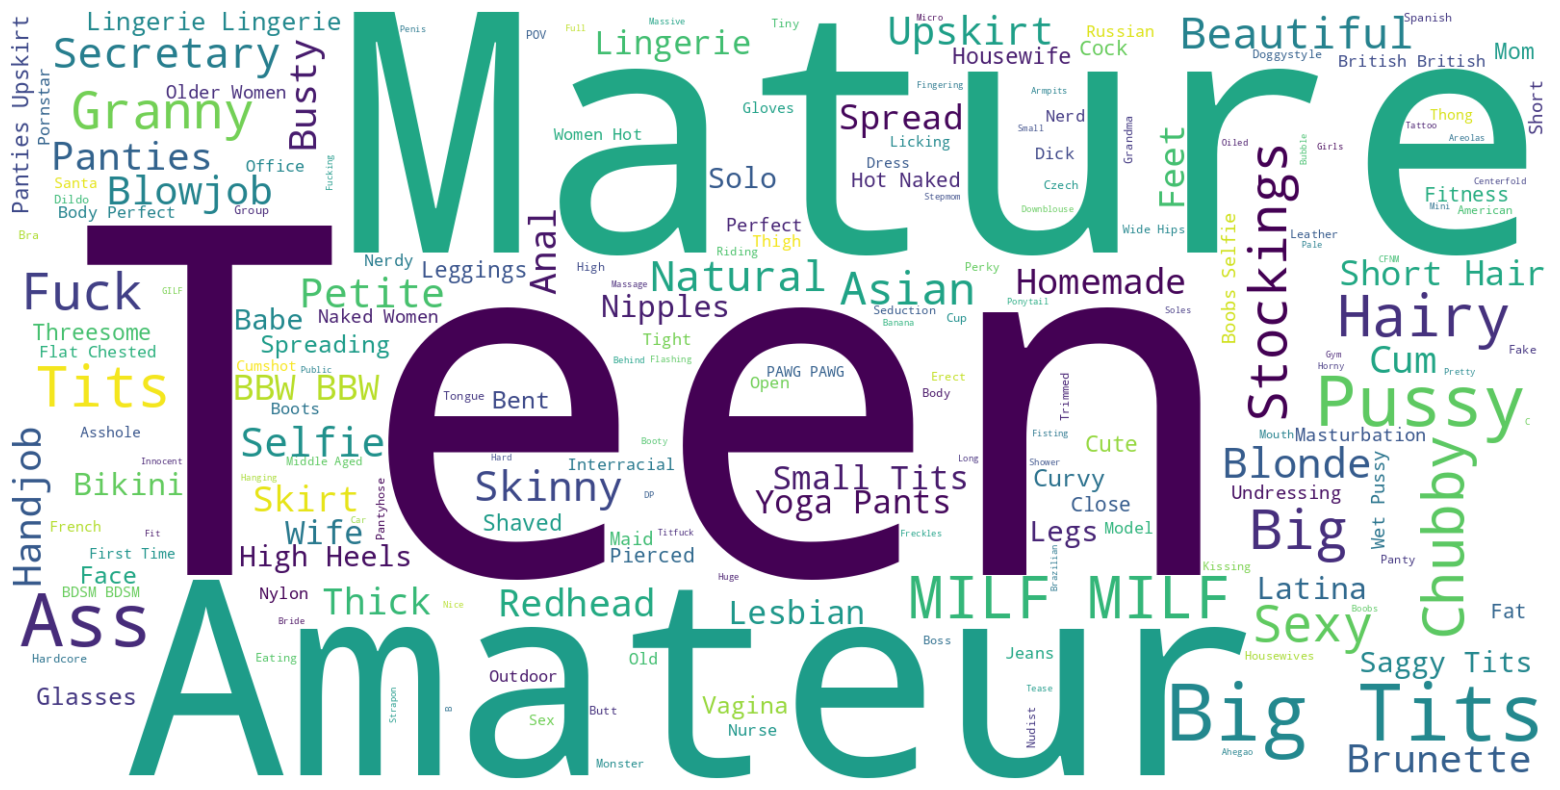

In [39]:
wordcloud = WordCloud(width=800 * 2, height=400 * 2, background_color='white').generate(
    " ".join([w.strip() for w in merged_list])
)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [42]:
merged_set = set(w.strip() for w in merged_list)
merged_set

{'69',
 'Ahegao',
 'Amateur  Upskirt',
 'Amateur Anal',
 'Amateur Ass',
 'Amateur Bikini',
 'Amateur Fuck',
 'Amateur Granny',
 'Amateur Hairy Pussy',
 'Amateur Handjob',
 'Amateur Homemade',
 'Amateur Housewife',
 'Amateur Interracial',
 'Amateur Latina',
 'Amateur Natural Tits',
 'Amateur Outdoor',
 'Amateur Petite',
 'Amateur Selfie',
 'Amateur Small Tits',
 'Amateur Solo',
 'Amateur Spreading',
 'Amateur Stockings',
 'Amateur Teen',
 'Amateur Teen Selfie',
 'Amateur Undressing',
 'Amateur Wife',
 'Amateur Yoga Pants',
 'American Mature',
 'Anal Threesome',
 'Asian Ass',
 'Asian Babe',
 'Asian Big Tits',
 'Asian Boots',
 'Asian Fake Tits',
 'Asian Lingerie',
 'Asian Solo',
 'Asian Teen',
 'Asian Upskirt',
 'Ass And Feet',
 'Ass In Shorts',
 'Ass Spread',
 'B Cup Tits',
 'BBW',
 'BDSM',
 'Banana Tits',
 'Beautiful',
 'Beautiful Asian',
 'Beautiful Ass',
 'Beautiful Face',
 'Beautiful Granny',
 'Beautiful Hairy',
 'Beautiful Mature',
 'Beautiful Pussy',
 'Beautiful Russian',
 'Beautif